# Titanic with neural network

In this notebook, I built a neural network model to predict survival on the Titanic dataset. I used PyTorch for model implementation and training, and I applied techniques like early stopping and learning rate scheduling to improve performance. The notebook includes data preprocessing, model definition, training loop, and evaluation of the model's performance on the test set.

TODO:
- Test different architectures (e.g., more layers, different activation functions)
- Improve the model with Name feature representation (flattening the name embeddings )
- I split the trainig data into train_train and train_val and, rougly, obtained a validation accuracy of 0.82. Should look into ways to improve this further, maybe with better hyperparameter tuning or more training epochs.
- For many of the hyperparameters I picked, I have the valuation accuracy greater than the test accuracy during training, which is unusual. This could be due to difference in train_train and train_val data. Should look into this.

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import numpy as np
import re
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train_df.shape)
print(test_df.shape)
train_df.head()

(891, 12)
(418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Analysis

In [4]:
# CHecking for null values and data types
train_df.isnull().sum(), train_df.isnull().sum()

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64)

In [5]:
print("Value counts for Cabin:")
print(train_df.Cabin.value_counts())
print("\nValue counts for Embarked:") 
print(train_df.Embarked.value_counts())

Value counts for Cabin:
Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

Value counts for Embarked:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


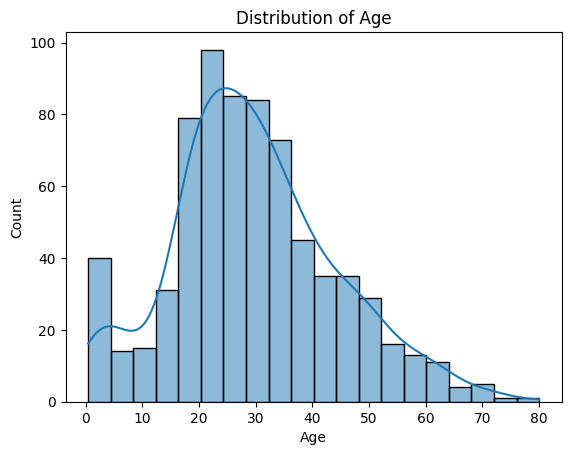

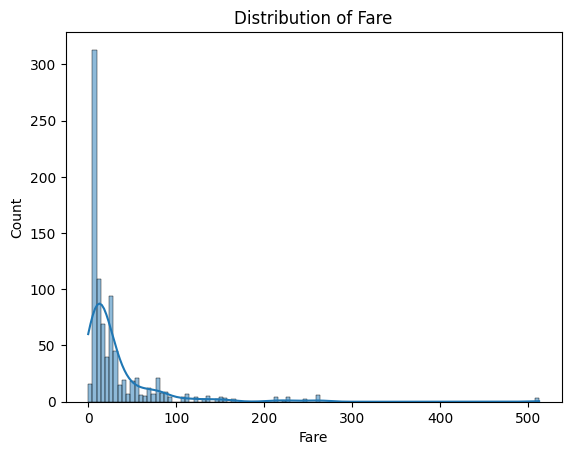

In [6]:
for col in ["Age", "Fare"]:
    sns.histplot(train_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

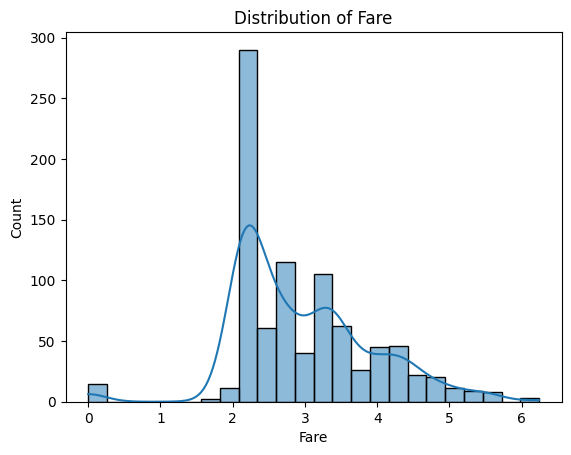

In [7]:
sns.histplot(np.log1p(train_df["Fare"]), kde=True) # because log is negative between 0 and 1, so log1p
plt.title(f"Distribution of Fare")
plt.show()

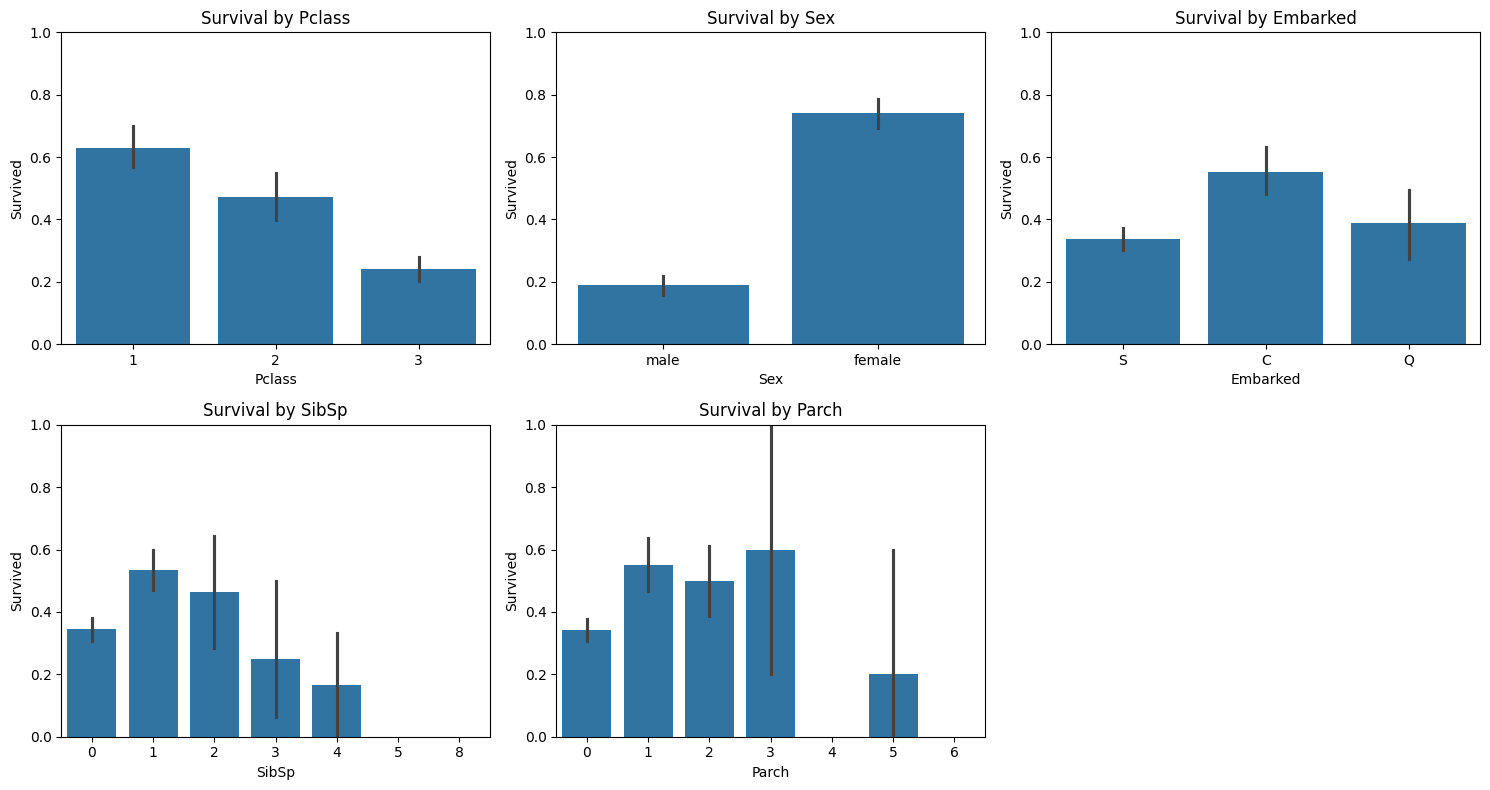

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(["Pclass", "Sex", "Embarked", "SibSp", "Parch"]):
    sns.barplot(x=col, y="Survived", data=train_df, ax=axes[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"Survival by {col}")

# Remove the extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [9]:
def get_cabin_number(cabin_val):
    if type(cabin_val) is str:
        cabin_int = re.findall(r"\d+", cabin_val)
        cabin_int = [int(x) for x in cabin_int]
        if cabin_int:
            return max(cabin_int)
    return np.nan

def get_cabin_char(cabin_val):
    if type(cabin_val) is str:
        if cabin_val[0].isalpha():
            return cabin_val[0]
    return np.nan

def get_title(name_val):
    matches = re.findall(r"\s\w+\.", name_val)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_marital_status(title_list):
    status = []
    for t in title_list:
        if "Mr." in t or "Mrs." in t:
            status.append(1)
        elif "Miss." in t or "Master." in t:
            status.append(0)
        else:
            status.append(-1)
    return status

Deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64
687


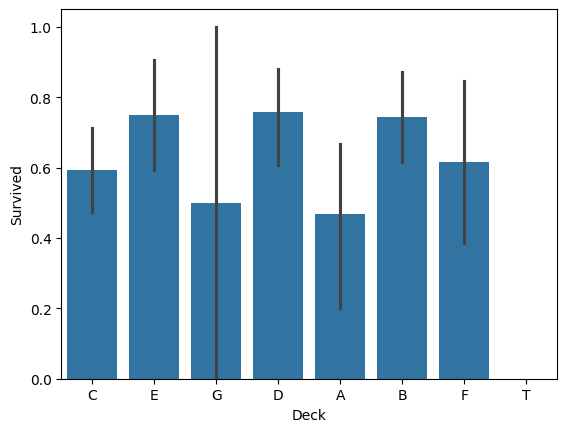

In [10]:
train_inspect_df = train_df.copy()
train_inspect_df['Deck'] = train_df['Cabin'].map(get_cabin_char)
sns.barplot(x="Deck", y="Survived", data=train_inspect_df)
print(train_inspect_df.Deck.value_counts())
print(train_inspect_df.Deck.isnull().sum())

In [11]:
deck_values = ["A", "B", "C", "D", "E", "F"] # because G and T have very few values, and to maintain consistency with test set.

def get_cabin_char_valid(cabin_val):
    cabin_char = get_cabin_char(cabin_val)
    if cabin_char in deck_values:
        return cabin_char
    return np.nan

## Data Preprocessing

In [12]:
all_names = train_df.Name.tolist() + test_df.Name.tolist()
all_words = set()

for name in all_names:
    cleand_words = re.sub(r'[^a-z\s]', '', name.lower())
    all_words.update([word for word in cleand_words.split()])
    
word_to_idx = {word: idx for idx, word in enumerate(all_words)}
name_vocab_size = len(word_to_idx)
print(f"Vocab size: {name_vocab_size}")

Vocab size: 1950


In [13]:
def prepare_sequence(seq_text, to_ix):
    seq_text = re.sub(r'[^a-z\s]', '', seq_text.lower())
    seq = seq_text.split()
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

train_names_vec = [prepare_sequence(name, word_to_idx) for name in train_df.Name]
test_names_vec = [prepare_sequence(name, word_to_idx) for name in test_df.Name]

all_names_vec = nn.utils.rnn.pad_sequence(train_names_vec + test_names_vec,
                                   padding_value=name_vocab_size,
                                   batch_first=True)

X_train_name = all_names_vec[: train_df.shape[0]]
X_test_name = all_names_vec[train_df.shape[0] : ]
X_train_name.shape

torch.Size([891, 14])

In [14]:
def preprocess_data(input_df):
    X_df = input_df.copy()

    # Label unknown values
    X_df['CabinKnown'] = np.where(X_df['Cabin'].isnull(), 0, 1)
    X_df['AgeKnown'] = np.where(X_df['Age'].isnull(), 0, 1)

    # Feature engineering
    X_df['Deck'] = X_df['Cabin'].map(get_cabin_char_valid)
    X_df['CabinNum'] = X_df['Cabin'].map(get_cabin_number)
    title = X_df['Name'].map(get_title)
    X_df['Married'] = get_marital_status(title)
    X_df['Fare'] = np.log1p(X_df['Fare']) # log transform to reduce skewness

    # Imputation
    X_df.fillna({"Fare": X_df["Fare"].median(skipna=True),
                "Embarked": X_df["Embarked"].mode(dropna=True)[0],
                "CabinNum": X_df["CabinNum"].median(skipna=True),
                "Age": X_df["Age"].median(skipna=True)
                }, inplace=True)

    # One-hot encoding
    X_df = pd.get_dummies(X_df, columns=["Pclass","Sex", "Embarked"], drop_first=True, dtype=int)
    X_df = pd.get_dummies(X_df, columns=["Deck"], drop_first=False, dtype=int) # because Deck has a lot of missing values

    # Dropping irrelevant features
    X_df.drop('PassengerId', axis=1, inplace=True)
    X_df.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
    
    X_df.drop('Survived', axis=1, inplace=True, errors='ignore')

    return X_df

# Apply preprocessing
X_train_other = preprocess_data(train_df)
X_test_other = preprocess_data(test_df)

assert X_train_other.shape[1] == X_test_other.shape[1], "Train and test sets have different number of features after preprocessing."

print(X_train_other.shape)
print("\nFirst few rows of processed data:")
print(X_train_other.head())

(891, 19)

First few rows of processed data:
    Age  SibSp  Parch      Fare  CabinKnown  AgeKnown  CabinNum  Married  \
0  22.0      1      0  2.110213           0         1      43.0        1   
1  38.0      1      0  4.280593           1         1      85.0        1   
2  26.0      0      0  2.188856           0         1      43.0        0   
3  35.0      1      0  3.990834           1         1     123.0        1   
4  35.0      0      0  2.202765           0         1      43.0        1   

   Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  Deck_A  Deck_B  \
0         0         1         1           0           1       0       0   
1         0         0         0           0           0       0       0   
2         0         1         0           0           1       0       0   
3         0         0         0           0           1       0       0   
4         0         1         1           0           1       0       0   

   Deck_C  Deck_D  Deck_E  Deck_F  
0       0  

In [15]:
# Normalize numeric features
numeric_features = ['Age', 'Fare', 'CabinNum', 'SibSp', 'Parch']
scaler = StandardScaler()

# Fit scaler on training data only (to avoid data leakage)
X_train_other[numeric_features] = scaler.fit_transform(X_train_other[numeric_features])
X_test_other[numeric_features] = scaler.transform(X_test_other[numeric_features])

print("\nFeature statistics after normalization:")
print(X_train_other[numeric_features].describe())


Feature statistics after normalization:
                Age          Fare      CabinNum         SibSp         Parch
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02
mean   2.272780e-16 -1.714553e-16  1.415503e-16  4.386066e-17  5.382900e-17
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00
min   -2.224156e+00 -3.058578e+00 -2.509766e+00 -4.745452e-01 -4.736736e-01
25%   -5.657365e-01 -8.002318e-01 -1.034181e-01 -4.745452e-01 -4.736736e-01
50%   -1.046374e-01 -2.316613e-01 -1.034181e-01 -4.745452e-01 -4.736736e-01
75%    4.333115e-01  5.198636e-01 -1.034181e-01  4.327934e-01 -4.736736e-01
max    3.891554e+00  3.385294e+00  6.059181e+00  6.784163e+00  6.974147e+00


In [16]:
# Check for any remaining null values
X_train_other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    float64
 2   Parch       891 non-null    float64
 3   Fare        891 non-null    float64
 4   CabinKnown  891 non-null    int64  
 5   AgeKnown    891 non-null    int64  
 6   CabinNum    891 non-null    float64
 7   Married     891 non-null    int64  
 8   Pclass_2    891 non-null    int64  
 9   Pclass_3    891 non-null    int64  
 10  Sex_male    891 non-null    int64  
 11  Embarked_Q  891 non-null    int64  
 12  Embarked_S  891 non-null    int64  
 13  Deck_A      891 non-null    int64  
 14  Deck_B      891 non-null    int64  
 15  Deck_C      891 non-null    int64  
 16  Deck_D      891 non-null    int64  
 17  Deck_E      891 non-null    int64  
 18  Deck_F      891 non-null    int64  
dtypes: float64(5), int64(14)
memo

## Model Building

In [17]:
# Early stopping: prevents overfitting by stopping when validation accuracy plateaus
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience  # Wait this many checks before stopping
        self.min_delta = min_delta  # Minimum improvement threshold
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        self.best_state_dict = None  # To save the best model weights
        
    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.best_state_dict = copy.deepcopy(model.state_dict())  # Deep copy to avoid mutation

        elif val_acc > self.best_score + self.min_delta:
            print(f"Validation accuracy improved from {self.best_score:.4f} to {val_acc:.4f}. Saving model.")
            self.best_score = val_acc
            self.best_state_dict = copy.deepcopy(model.state_dict())  # Deep copy to avoid mutation
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [18]:
np.random.seed(3)

# Splitting trainig and validation data
train_indices = np.random.choice(train_df.shape[0], 
                                 size=int(0.8*train_df.shape[0]), 
                                 replace=False).tolist()
val_indices = [i for i in range(len(train_df)) if i not in train_indices]

X_train_train_name = X_train_name[train_indices].to(device)
X_train_val_name = X_train_name[val_indices].to(device)

X_train_train_other = torch.tensor(X_train_other.iloc[train_indices].values, dtype=torch.float32).to(device)
X_train_val_other = torch.tensor(X_train_other.iloc[val_indices].values, dtype=torch.float32).to(device)

y_train_train = torch.tensor(train_df.iloc[train_indices]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
y_train_val = torch.tensor(train_df.iloc[val_indices]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
print(y_train_train.device)

cpu


### Without Name representation

In [84]:
class TitanicSurvivalModelOther(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0):
        super(TitanicSurvivalModelOther, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 10)
        self.fc3 = nn.Linear(10, 4)
        self.fc4 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def model_other_accuracy(model, other_features, labels, print_report=False):
    model.eval()
    with torch.no_grad():
        outputs = model(other_features)
        predicted = (F.sigmoid(outputs) >= 0.5).float()  # Apply sigmoid for prediction
        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
        if print_report:
            print(classification_report(labels.cpu(), predicted.cpu()))

    return accuracy

In [89]:
# Intialize model, loss function, and optimizer
model_other = TitanicSurvivalModelOther(X_train_other.shape[1], dropout_rate=0.0).to(device)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(model_other.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.2, patience=3
)

print(f"Model initialized with:")
print(f"\nModel architecture:\n{model_other}")
print("# model parameters: ", sum([p.numel() for p in model_other.parameters()]))

Model initialized with:

Model architecture:
TitanicSurvivalModelOther(
  (fc1): Linear(in_features=19, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
# model parameters:  779


In [90]:
# Model before training
model_other_accuracy(model_other, X_train_val_other, y_train_val, print_report=True)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       106
         1.0       0.41      1.00      0.58        73

    accuracy                           0.41       179
   macro avg       0.20      0.50      0.29       179
weighted avg       0.17      0.41      0.24       179



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.40782122905027934

In [91]:
# Training loop
num_epochs = 50
batch_size = 64
model_other.to(device)

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    model_other.train()
    indices = torch.randperm(len(X_train_train_name), generator=torch.Generator().manual_seed(epoch))
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        
        other_features = X_train_train_other[batch_indices]
        target = y_train_train[batch_indices]
        
        # Forward pass
        optimizer.zero_grad()
        output = model_other(other_features)
        loss = criterion(output, target, )
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(X_train_train_other)
    
    model_other.eval()
    with torch.no_grad():
        val_outputs = model_other(X_train_val_other)
        val_loss = criterion(val_outputs, y_train_val)
        val_loss = val_loss / len(X_train_val_other)
        train_acc = model_other_accuracy(model_other, X_train_train_other, y_train_train)
        val_acc = model_other_accuracy(model_other, X_train_val_other, y_train_val)
    
    scheduler.step(val_acc)
    training_losses.append(avg_loss)
    validation_losses.append(val_loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_acc, model=model_other)
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\nTraining completed!")

Epoch [1/50], Train Loss: 0.7014, Val Loss: 0.6952, Train Acc: 0.4228, Val Acc: 0.4525
Epoch [2/50], Train Loss: 0.6941, Val Loss: 0.6882, Train Acc: 0.5744, Val Acc: 0.6257
Validation accuracy improved from 0.4525 to 0.6257. Saving model.
Epoch [3/50], Train Loss: 0.6851, Val Loss: 0.6771, Train Acc: 0.6376, Val Acc: 0.6034
Epoch [4/50], Train Loss: 0.6735, Val Loss: 0.6660, Train Acc: 0.6461, Val Acc: 0.6089
Epoch [5/50], Train Loss: 0.6616, Val Loss: 0.6522, Train Acc: 0.6433, Val Acc: 0.6034
Epoch [6/50], Train Loss: 0.6461, Val Loss: 0.6371, Train Acc: 0.6503, Val Acc: 0.6145
Epoch [7/50], Train Loss: 0.6360, Val Loss: 0.6337, Train Acc: 0.6517, Val Acc: 0.6145
Epoch [8/50], Train Loss: 0.6326, Val Loss: 0.6302, Train Acc: 0.6545, Val Acc: 0.6145
Epoch [9/50], Train Loss: 0.6294, Val Loss: 0.6267, Train Acc: 0.6559, Val Acc: 0.6257
Epoch [10/50], Train Loss: 0.6262, Val Loss: 0.6230, Train Acc: 0.6559, Val Acc: 0.6257
Epoch [11/50], Train Loss: 0.6239, Val Loss: 0.6223, Train Acc:

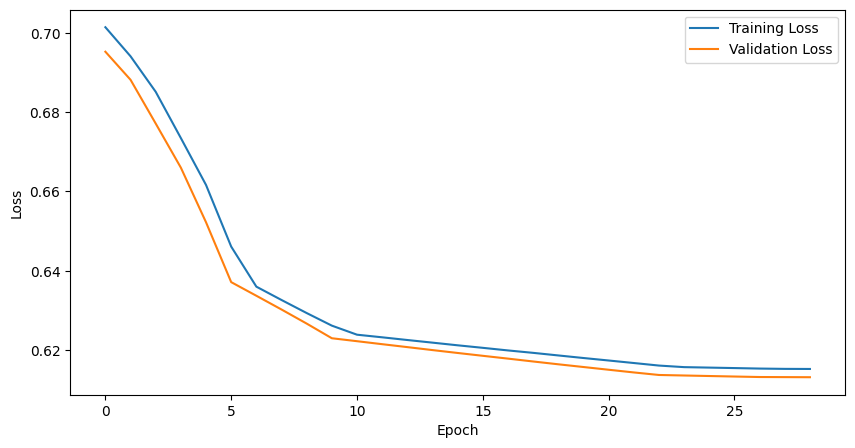

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [83]:
best_model = TitanicSurvivalModelOther(X_train_other.shape[1])
best_model.load_state_dict(early_stopping.best_state_dict)
best_model.to(device)
print("\nBest model performance on validation set:")
model_other_accuracy(best_model, X_train_val_other, y_train_val, print_report=True)


Best model performance on validation set:
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89       106
         1.0       0.93      0.73      0.82        73

    accuracy                           0.87       179
   macro avg       0.88      0.84      0.86       179
weighted avg       0.87      0.87      0.86       179



0.8659217877094972

### K-Fold Cross-Validation

In [97]:
# K-Fold Cross-Validation for more reliable performance estimates
np.random.seed(42)
torch.manual_seed(42)

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_train_accs = []
fold_val_accs = []
fold_best_val_accs = []

print(f"Starting {n_folds}-Fold Cross-Validation\n")
print("="*60)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df), 1):
    print(f"\nFold {fold}/{n_folds}")
    print("-"*60)
    
    # Split data for this fold
    X_train_fold_other = torch.tensor(X_train_other.iloc[train_idx].values, dtype=torch.float32).to(device)
    X_val_fold_other = torch.tensor(X_train_other.iloc[val_idx].values, dtype=torch.float32).to(device)
    
    y_train_fold = torch.tensor(train_df.iloc[train_idx]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
    y_val_fold = torch.tensor(train_df.iloc[val_idx]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Initialize model, optimizer, and early stopping for this fold
    model_fold = TitanicSurvivalModelOther(X_train_other.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_fold.parameters(), lr=0.005)
    early_stopping_fold = EarlyStopping(patience=7, min_delta=0.001)
    
    # Training loop for this fold
    num_epochs = 100
    batch_size = 32
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        model_fold.train()
        indices = torch.randperm(len(X_train_fold_other))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            other_features = X_train_fold_other[batch_indices]
            target = y_train_fold[batch_indices]
            
            # Forward pass
            optimizer.zero_grad()
            output = model_fold(other_features)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Validation
        model_fold.eval()
        with torch.no_grad():
            val_outputs = model_fold(X_val_fold_other)
            val_loss = criterion(val_outputs, y_val_fold)
            train_acc = model_other_accuracy(model_fold, X_train_fold_other, y_train_fold)
            val_acc = model_other_accuracy(model_fold, X_val_fold_other, y_val_fold)
        
        # Early stopping check
        early_stopping_fold(val_acc, model=model_fold)
        if early_stopping_fold.early_stop:
            break
    
    # Store best results for this fold
    best_val_acc = early_stopping_fold.best_score
    fold_best_val_accs.append(best_val_acc)
    
    # Load best model for final evaluation
    model_fold.load_state_dict(early_stopping_fold.best_state_dict)
    final_train_acc = model_other_accuracy(model_fold, X_train_fold_other, y_train_fold)
    final_val_acc = model_other_accuracy(model_fold, X_val_fold_other, y_val_fold)
    
    fold_train_accs.append(final_train_acc)
    fold_val_accs.append(final_val_acc)
    
    print(f"Fold {fold} - Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Best Val Acc: {best_val_acc:.4f}")

print("\n" + "="*60)
print("Cross-Validation Results:")
print("="*60)
print(f"Mean Train Accuracy: {np.mean(fold_train_accs):.4f} ± {np.std(fold_train_accs):.4f}")
print(f"Mean Val Accuracy:   {np.mean(fold_val_accs):.4f} ± {np.std(fold_val_accs):.4f}")
print(f"Best Val per Fold:   {np.mean(fold_best_val_accs):.4f} ± {np.std(fold_best_val_accs):.4f}")
print("\nIndividual Fold Val Accuracies:", [f"{acc:.4f}" for acc in fold_val_accs])

Starting 5-Fold Cross-Validation


Fold 1/5
------------------------------------------------------------
Validation accuracy improved from 0.5866 to 0.7765. Saving model.
Validation accuracy improved from 0.7765 to 0.8547. Saving model.
Fold 1 - Train Acc: 0.8132, Val Acc: 0.8547, Best Val Acc: 0.8547

Fold 2/5
------------------------------------------------------------
Validation accuracy improved from 0.7247 to 0.7360. Saving model.
Validation accuracy improved from 0.7360 to 0.7697. Saving model.
Validation accuracy improved from 0.7697 to 0.7921. Saving model.
Validation accuracy improved from 0.7921 to 0.8090. Saving model.
Validation accuracy improved from 0.8090 to 0.8146. Saving model.
Fold 2 - Train Acc: 0.8443, Val Acc: 0.8146, Best Val Acc: 0.8146

Fold 3/5
------------------------------------------------------------
Validation accuracy improved from 0.6067 to 0.7921. Saving model.
Validation accuracy improved from 0.7921 to 0.7978. Saving model.
Validation accuracy improve

### With Name representation

In [ ]:
class TitanicSurvivalModel(nn.Module):
    def __init__(self, name_vocab_size, max_name_length, name_embedding_dim, other_feature_dim):
        super(TitanicSurvivalModel, self).__init__()
        self.name_embedding = nn.Embedding(name_vocab_size + 1, name_embedding_dim)
        self.fc1 = nn.Linear((name_embedding_dim * max_name_length) + other_feature_dim, 28)  # 32 for hidden dimension
        self.fc2 = nn.Linear(28, 8)
        self.fc3 = nn.Linear(8, 1)
    
    def forward(self, name_vec, other_features):
        # print("Input shapes:")
        # print(name_vec.shape, other_features.shape)

        embedded = self.name_embedding(name_vec)  # Simple average of embeddings
        # print("Embedded shape:", embedded.shape)
        embedded = torch.flatten(embedded, start_dim=1)

        x = torch.cat((embedded, other_features), dim=-1)
        # print("x shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No sigmoid - BCEWithLogitsLoss handles it
        return x

In [ ]:
def model_accuracy(model, name_vec, other_features, labels, print_report=False):
    model.eval()
    with torch.no_grad():
        outputs = model(name_vec, other_features)
        predicted = (F.sigmoid(outputs) >= 0.5).float()  # Apply sigmoid for prediction
        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
        if print_report:
            print(classification_report(labels.cpu(), predicted.cpu()))

    return accuracy

In [ ]:
# Initialize the model
model = TitanicSurvivalModel(name_vocab_size = name_vocab_size, 
                             max_name_length = X_train_name.shape[1], 
                             name_embedding_dim = 5, 
                             other_feature_dim = X_train_other.shape[1])

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # More numerically stable than BCELoss + sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"Model initialized with:")
print(f"\nModel architecture:\n{model}")
print("# model parameters: ", sum([p.numel() for p in model.parameters()]))

Model initialized with:

Model architecture:
TitanicSurvivalModel(
  (name_embedding): Embedding(1951, 5)
  (fc1): Linear(in_features=90, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
# model parameters:  12544


In [ ]:
# Model before training
model_accuracy(model, X_train_val_name, X_train_val_other, y_train_val, print_report=True)

              precision    recall  f1-score   support

         0.0       0.89      0.07      0.14       108
         1.0       0.41      0.99      0.58        71

    accuracy                           0.44       179
   macro avg       0.65      0.53      0.36       179
weighted avg       0.70      0.44      0.31       179



0.43575418994413406

In [ ]:
# Training loop
num_epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=5, min_delta=0.0002)
model.to(device)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    model.train()
    indices = torch.randperm(len(X_train_train_name), generator=torch.Generator().manual_seed(epoch))
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        
        name_vec = X_train_train_name[batch_indices]
        other_features = X_train_train_other[batch_indices]
        target = y_train_train[batch_indices]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(name_vec, other_features)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / (len(X_train_train_name) / batch_size)
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_val_name, X_train_val_other)
        val_loss = criterion(val_outputs, y_train_val)
        train_acc = model_accuracy(model, X_train_train_name, X_train_train_other, y_train_train)
        val_acc = model_accuracy(model, X_train_val_name, X_train_val_other, y_train_val)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_acc, model=model)
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\nTraining completed!")

Epoch [1/100], Train Loss: 0.7421, Val Loss: 0.6805, Train Acc: 0.6938, Val Acc: 0.6704
Epoch [2/100], Train Loss: 0.7260, Val Loss: 0.6651, Train Acc: 0.6601, Val Acc: 0.6257
Epoch [3/100], Train Loss: 0.7130, Val Loss: 0.6513, Train Acc: 0.6489, Val Acc: 0.6313
Epoch [4/100], Train Loss: 0.6884, Val Loss: 0.6386, Train Acc: 0.6573, Val Acc: 0.6425
Epoch [5/100], Train Loss: 0.6823, Val Loss: 0.6224, Train Acc: 0.6573, Val Acc: 0.6480
Epoch [6/100], Train Loss: 0.6527, Val Loss: 0.6005, Train Acc: 0.6868, Val Acc: 0.6480

Early stopping triggered at epoch 6

Training completed!


In [ ]:
best_model = TitanicSurvivalModel(name_vocab_size = name_vocab_size, 
                                 max_name_length = X_train_name.shape[1], 
                                 name_embedding_dim = 5, 
                                 other_feature_dim = X_train_other.shape[1])
best_model.load_state_dict(early_stopping.best_state_dict)
best_model.to(device)
print("\nBest model performance on validation set:")
model_accuracy(best_model, X_train_val_name, X_train_val_other, y_train_val)


Best model performance on validation set:


0.6480446927374302